# eTransafe Omeprazole Heatmap

This is the use scenario that has been described in the eTox project for exploring the differences with respect to adverse events between omeprazole preclinical and clinical. In order to compute these results the following scenario is executed:
1. Translate the provided compound (e.g., omeprazole) to a SMILES
2. Retrieve similar compounds based on structural similarity
3. Retrieve data from the preclinical and clinical databases
4. Aggregate the data per system organ class
5. Visualize the data using a heatmap

(C) 2021 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [2]:
from kh.api import KnowledgeHubAPI
import ipywidgets as w
from IPython.display import display, Javascript
from ipypublish import nb_setup
import numpy as np
import numpy.ma as ma
import seaborn as sns
import pandas
import matplotlib.pyplot as plt

In [3]:
api = KnowledgeHubAPI()

## 1. Translate compound to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [4]:
compoundName = w.Text(value='omeprazole',placeholder='compound name', description='compound:', disabled=False)
compoundBtn = w.Button(description='Retrieve')
compoundSmile = None

def on_compound_entered(_):
        compound = api.SemanticService().normalize(compoundName.value, ['RxNorm','smiles'])
        if 'concepts' in compound:
            for concept in compound['concepts']:
                if 'vocabularyId' in concept:
                    if concept['vocabularyId'] == 'smiles':
                        global compoundSmile
                        compoundSmile = concept['conceptCode']
                        print(f'Found SMILES {compoundSmile} for {compoundName.value}')
                        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

compoundBtn.on_click(on_compound_entered) 
w.VBox([compoundName, compoundBtn])

Found SMILES COc1ccc2[nH]c(nc2c1)[S+]([O-])Cc3ncc(C)c(OC)c3C for omeprazole


<IPython.core.display.Javascript object>

In [6]:
compoundIds = []
compoundNames = []
names = []
smiles = []
similarities = []

## 2. Retrieve similar compounds

In [7]:
similar_compounds = api.SimilarityService().get(compoundSmile, nr_results = 20)

if similar_compounds != None:
    if ('search_results' in similar_compounds) and (len(similar_compounds['search_results']) == 1):
        search_result = similar_compounds['search_results'][0]
        if 'obj_nam' in search_result:
            for i in range(len(search_result['obj_nam'])):
                names.append(search_result['obj_nam'][i])
                smiles.append(search_result['SMILES'][i])
                similarities.append("{:.4f}".format(search_result['distances'][i]))

            for cmp in search_result['obj_nam']:
                concept = api.SemanticService().normalize(cmp, ['RxNorm'])
                if 'concepts' in concept and len(concept['concepts']) == 1:
                    compoundIds.append(concept['concepts'][0]['conceptCode'])
                    compoundNames.append(concept['concepts'][0]['conceptName'])
        else:
            print('something wrong in the result object from the similarity service')    

pd = nb_setup.setup_pandas(escape_latex=False)
df = pd.DataFrame(np.random.rand(len(names),3),columns=['NAME','SMILES','SIMILARITY'])
df.NAME = names
df.SMILES = smiles
df.SIMILARITY = similarities
df.round(3)

status_code:404
status_code:200


,NAME,SMILES,SIMILARITY
0,Omeprazole,COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,1.0000
1,rabeprazole,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,0.6275
2,dexlansoprazole,Cc1c(OCC(F)(F)F)ccnc1C[S@@+]([O-])c1nc2ccccc2[...,0.6078
3,Zoton,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,0.6078
4,Esomeprazole_Strontium,COc1ccc2[n-]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc...,0.5957


# 3. Retrieve data from the preclinical and clinical databases

In [8]:
studies = {
    'Medline': api.Medline().getStudiesByCompoundIds(compoundIds),
    'FAERS': api.Faers().getStudiesByCompoundIds(compoundIds),
    'ClinicalTrials': api.ClinicalTrials().getStudiesByCompoundIds(compoundIds),
    'eTOXSys': api.eToxSys().getStudiesByCompoundNames(compoundNames)
}

count = 0
for source in studies:
    count += len(studies[source])
print(f'Found {count} studies.')

Found 9249 studies.


# 4. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [10]:
system = {}
all_compounds = [c.lower() for c in compoundNames]
socs = {}
socs_labels = []

# retrieve all system organ classes used
for source in studies:
    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    if specimenOrgan not in socs:
                        socs[specimenOrgan] = 0
                        socs_labels.append(specimenOrgan)

# travers the studies and count distinct findings per system organ class
for source in studies:
    # initialize for each source again a data structure to capture per combination of a system organ class 
    # and a compound what findings have been found
    findings_rows_cols = [[[] for compound in all_compounds] for soc in socs_labels]
        
    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    compound = study['COMPOUND']['name'].lower()
                    row = socs_labels.index(specimenOrgan)
                    col = all_compounds.index(compound)
                    finding = study['FINDING']['finding']
                    if finding not in findings_rows_cols[row][col]:
                        socs[specimenOrgan] += 1
                        findings_rows_cols[row][col].append(finding)
          
# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}

# traverse all studies and create a matrix per source
for source in studies:
    system[source] = {
        'data':np.zeros((len(all_socs),len(all_compounds)), dtype=int).tolist(), 
        'rows':list(all_socs.keys()), 
        'cols':all_compounds
    }

    # initialize for each source again a data structure to capture per combination of a system organ class 
    # and a compound what findings have been found
    findings_rows_cols = [[[] for compound in all_compounds] for soc in socs_labels]
        
    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    row = system[source]['rows'].index(specimenOrgan)
                    col = system[source]['cols'].index(study['COMPOUND']['name'].lower())
                    finding = study['FINDING']['finding']
                    if finding not in findings_rows_cols[row][col]:
                        system[source]['data'][row][col] += 1
                        findings_rows_cols[row][col].append(finding)


                

# 5. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

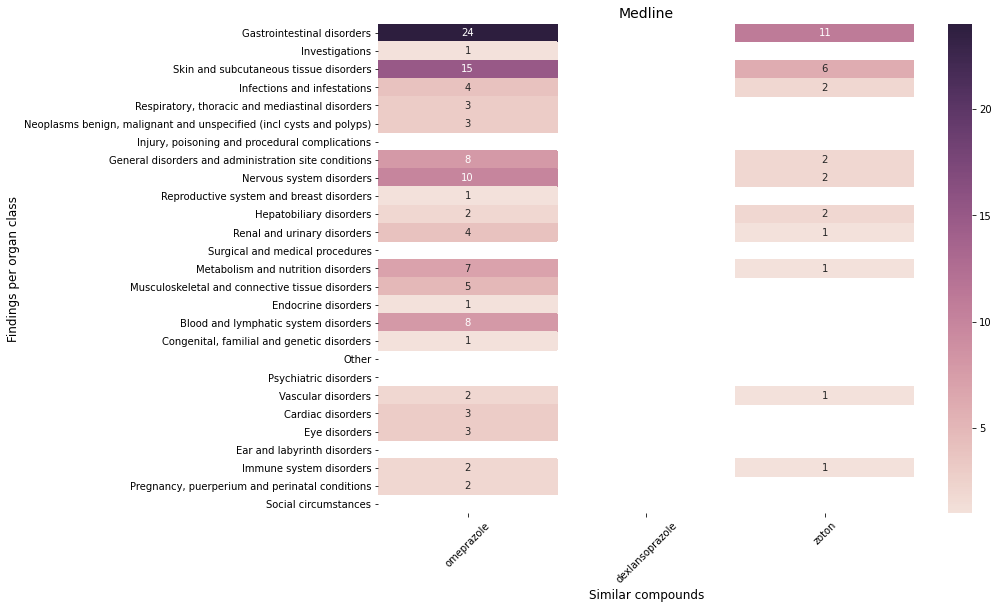

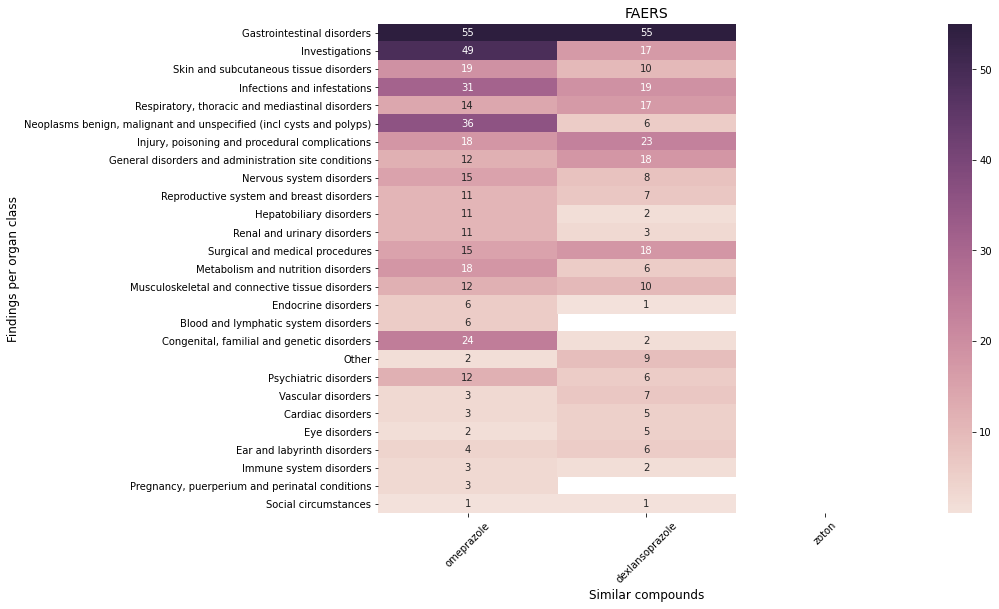

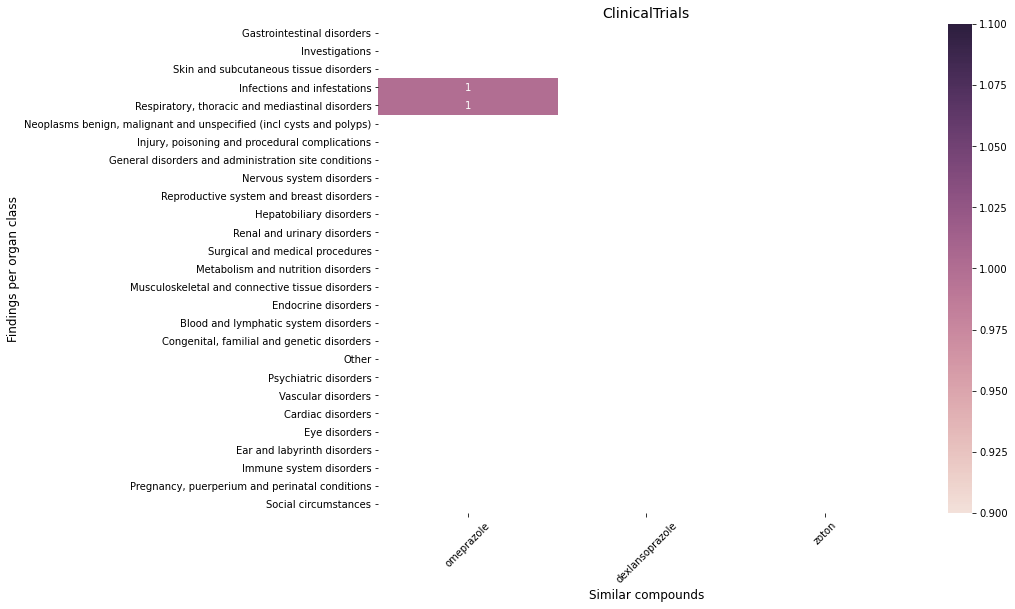

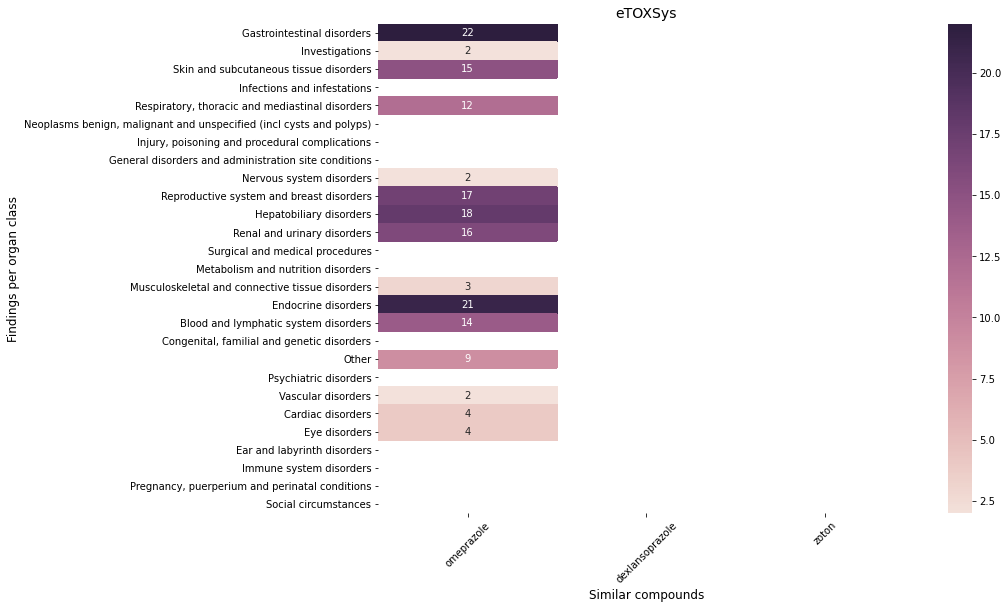

In [11]:
i = 1
for source,value in system.items():
    plt.figure(figsize=(12,9))
    data = system[source]['data']
    
    # create mask
    data_mask = ma.array(np.zeros((len(all_socs.keys()), len(all_compounds))))
    for r in range(0, len(all_socs.keys())):
        for c in range(0, len(all_compounds)):
            data_mask[r][c] = 1 if data[r][c] == 0 else 0

    colormap = sns.cubehelix_palette(as_cmap=True, light=.9)
    ax = sns.heatmap(data, mask=data_mask, xticklabels=all_compounds, yticklabels=list(all_socs.keys()), annot=True, fmt=".0f", cmap=colormap) 
    ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45)
    plt.title(source, fontsize = 14)
    plt.ylabel("Findings per organ class", fontsize = 12)
    plt.xlabel("Similar compounds", fontsize = 12)
    plt.show()

    i += 1
    print('')
    print('')